- 광고 추천에는 user와 ad 사이의 interaction을 고려하는 것이 중요하다.
- classification의 가장 대표적인 logit regression의 경우 linear한 영향만 고려하기 때문에 interaction을 고려하지 못한다.
- Factorization Mahine(FM)은 광고 추천에 활용하면 user와 ad사이의 interaction을 고려한 알고리즘을 구축할 수 있다.
- 본 노트에서는 FM을 활용하여서 CTR 예측 알고리즘을 구축해보겠다.
- CTR 데이터의 class는 positive class인 click(+1)과 negative class인 unclick(-1)로 구성되어있다. pisitive class는 전체 샘플 중  1~10%밖에 차지하지 않아서 클래스 불균형 문제가 존재한다.
- 본 노트에서는 클래스 불균형 문제가 있는 CTR 데이터에 대해서 FM을 구축하여서 CTR 예측을 해보겠다.
    - 데이터로는 fastFM에서 제공하는 FM 테스트 용 랜덤 데이터에 클래스 불균형을 준 데이터를 사용할 것이다.

## 목차
1. [데이터 생성 및 탐색](#1.데이터-생성-및-탐색)
1. [전처리 없이 FM으로 CTR 예측](#2.전처리-없이-FM으로-CTR-예측)
1. [비용민감모델로 클래스 불균형 문제 해결하기](#3.비용민감모델로-클래스-불균형-문제-해결하기)
1. [재샘플링으로 클래스 불균형 문제 해결하기](#4.재샘플링으로-클래스-불균형-문제-해결하기)

**Accuracy, Precision, Recall, F1 score 구하기**


In [27]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import minmax_scale


import time
import warnings
warnings.filterwarnings('ignore')

## 1.데이터 생성 및 탐색

In [18]:
from fastFM.datasets import make_user_item_regression

# This sets up a small test dataset.
X, y, _ = make_user_item_regression(n_user=100, n_item=100)

# Convert dataset to binary classification task.
y_labels = np.ones_like(y)
for_imbalance = 223 #클래스 불균형을 만들기위한 수치
y_labels[y < for_imbalance] = -1 
#print(y_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y_labels)
#print(X_train.toarray())


In [51]:
#CTR 확인

print('[train] CTR = number of +1/number of y : ', round(100*(y_train==1).sum()/len(y_train),2),'%')
print('[test] CTR = number of +1/number of y : ', round(100*(y_test==1).sum()/len(y_test),2),'%')


[train] CTR = number of +1/number of y :  7.07 %
[test] CTR = number of +1/number of y :  7.68 %


## 2.전처리 없이 FM으로 CTR 예측
1. fast FM
- 전처리를 수행하지 않고 FM을 돌려본다.

In [102]:
from fastFM import sgd

# check time
start_time = time.time()

# fastFM = sgd.FMClassification(n_iter=1000, init_stdev=0.1, rank=2, step_size=0.02)
fastFM = sgd.FMClassification(n_iter=100000, init_stdev=0.1, l2_reg_w=0,\
                          l2_reg_V=0, rank=2, step_size=0.1)
fastFM.fit(X_train, y_train)

preds_fm = fastFM.predict(X_test)

print('Accuracy:', round(accuracy_score(y_test, preds_fm),3))
print('Precision: ', round(precision_score(y_test, preds_fm),3))
print('Recall: ', round(recall_score(y_test, preds_fm),3))
print('F1-score: ', round(f1_score(y_test, preds_fm),3))
print('CTR: ', 100*(preds_fm==1).sum()/len(preds_fm),'%')
# check time
print("--- %s seconds ---" % (time.time() - start_time))

Accuracy: 0.984
Precision:  0.947
Recall:  0.839
F1-score:  0.89
Ratio:  6.8 %
--- 0.02325129508972168 seconds ---


In [103]:
print('[test set] CTR: ', 100*(y_test==1).sum()/len(y_test),'%')

[test set] CTR:  7.68 %


- 데이터 자체가 FM를 테스트하기 위해 만들어진 데이터이다 보니 accuracy 자체가 상당히 잘 나오고, 클래스 불균형을 해결하지 않아도 F1-score이 크다.
- 하지만 그래도 불균형된 데이터이다 보니 accuracy나 precision에 비해서 recall과 F1-score이 낮게 나옴을 확인할 수 있다.
- 그리고 정답셋에 비해서 positve class의 비율인 CTR이 낮아짐을 확인할 수 있다.
    - 정답 CTR : 7.68%, 예측 CTR: 6.8%
- 데이터의 클래스불균형 문제를 해결하여 predicted CTR(pCTR)의 정확도를 높여보겠다.

# 3.비용민감모델로 pCTR 정확도 높이기
- 전략
    - fastFM 라이브러리에서는 classification이 될 확률을 계산하여 0과 1사이의 값으로 출력해주는 기능을 제공해주고 있다.
    - 확률로 예측값을 얻어내어 class가 나눠지는 threshold을 조정하여 FM을 비용민감모델로 만들어 본다. 
    - 가장 적절한 threshold를 구한다.

In [104]:
# probability 형태로도 예측 가능
pred_proba = fastFM.predict_proba(X_test)
pred_proba = minmax_scale(pred_proba)

In [83]:
#threshold
alpha_ls = [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7]
acc_ls, prec_ls, recall_ls, f1_ls, ratio_ls = [], [], [], [], []

for alpha in alpha_ls:

    #classification
    pred_proba[pred_proba < alpha] = -1
    pred_proba[pred_proba >= alpha] = 1
    
#     print('-------------')
#     print('alpha: ', alpha)
#     print('accuracy:', round(accuracy_score(y_test, pred_proba),3))
#     print('precision: ', round(precision_score(y_test, pred_proba),3))
#     print('recall: ', round(recall_score(y_test, pred_proba),3))
#     print('f1-score: ', round(f1_score(y_test, pred_proba),3))
#     print('raito: ', round(100*(pred_proba==1).sum()/len(pred_proba),2),'%')
    
    acc_ls+=[round(accuracy_score(y_test, pred_proba),3)]
    prec_ls+=[round(precision_score(y_test, pred_proba),3)]
    recall_ls+=[round(recall_score(y_test, pred_proba),3)]
    f1_ls+=[round(f1_score(y_test, pred_proba),3)]
    ratio_ls+=[round(100*(pred_proba==1).sum()/len(pred_proba),2)]

In [106]:
data = {'Threshold': alpha_ls, 'Accuracy':acc_ls, 'Precision':prec_ls, \
        'Recall':recall_ls, 'F1-score':f1_ls, 'Ratio':ratio_ls}
pd.DataFrame(data)

,Threshold,Accuracy,Precision,Recall,F1-score,Ratio
0,0.20,0.984,0.863,0.948,0.903,8.44
1,0.25,0.986,0.898,0.922,0.910,7.88
2,0.30,0.986,0.911,0.911,0.911,7.68
3,0.35,0.985,0.919,0.885,0.902,7.40
4,0.40,0.985,0.933,0.870,0.900,7.16
5,0.45,0.985,0.948,0.854,0.899,6.92
6,0.50,0.984,0.947,0.839,0.890,6.80
7,0.55,0.982,0.945,0.812,0.874,6.60
8,0.60,0.980,0.955,0.781,0.860,6.28
9,0.65,0.978,0.960,0.750,0.842,6.00


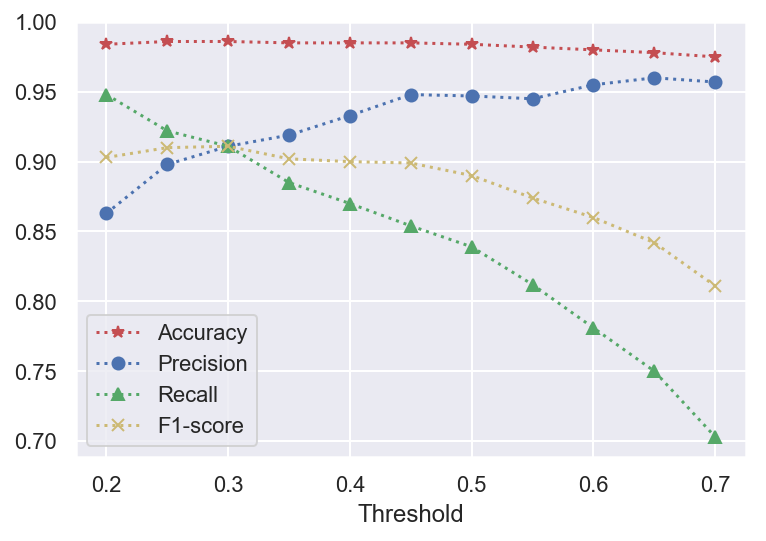

In [107]:
plt.plot(alpha_ls, acc_ls,'r*:', label='Accuracy') 
plt.plot(alpha_ls, prec_ls, 'bo:', label='Precision')
plt.plot(alpha_ls, recall_ls, 'g^:', label='Recall')
plt.plot(alpha_ls, f1_ls, 'yx:', label='F1-score')
plt.legend(loc=0)
plt.xlabel('Threshold')
plt.show()

- Threshold를 작게 만들어서 민감하게 만들 수록 recall은 커지는 반면에 precision은 작아진다.
    즉, negative class에 대한 정확도를 희생해서 positve class의 정확도를 올린 것.
- precision을 얼마나 희생하고 recall을 올릴 것인가의 문제가 있기 때문에 F1-score로 판단.
- F1-score은 threshold=0.3일 때가 가장 최대치. 그리고 이때 CTR(=#of+1/total)도 예측값과 정답이 7.68 동일해짐.
- 따라서 threshold=0.3으로 설정하여 FM을 비용민감모델로 만든다면 정확한 CTR값을 예측할 수 있다.

# 4.재샘플링으로 클래스 불균형 문제 해결하기